In [50]:
# Probably better to put everything in Dockerfile
# !pip install seaborn
# !pip install timm
# !pip install albumentations==0.4.6
# !pip install opencv-python

# Recommend doing this in CLI
# !export DEBIAN_FRONTEND=noninteractive
# !export TZ=America
# !apt-get install ffmpeg libsm6 libxext6  -y

In [163]:
## Imports
import os
import glob
import sys
import shutil
import re
import time
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style='ticks')
sns.set_context("notebook", rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})  
from IPython.display import display, Image
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 22})
%matplotlib inline
import imageio

from tqdm import tqdm_notebook as tqdm
#import tqdm.notebook import tqdm
import cv2
import torch
import albumentations as A
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from sklearn.utils import shuffle
import timm
import warnings
warnings.filterwarnings('ignore')
root_dir = '/workspace/'

### Check out USED dataset structure

In [13]:
!ls -lh data/

total 62G
drwxr-xr-x 4 1000 1000 4.0K Apr 13  2017 'CSV files for SED-EImm'
-rw------- 1 1000 1000 5.4M Sep 20 07:22  CSV-files-for-SED-EiMM.zip
-rw------- 1 1000 1000  21G Sep 16 01:17  USED-test.tar.gz
-rw------- 1 1000 1000  41G Sep 16 04:00  USED-training.tar.gz
drwxrwxr-x 3 1000 1000 4.0K Apr 13  2017  __MACOSX
drwx------ 2 1000 1000 4.0M Feb 19  2016  test-part1
drwx------ 2 1000 1000 3.9M Feb 18  2016  test-part2
drwx------ 2 1000 1000 9.1M Sep 20 07:19  train-part1
drwx------ 2 1000 1000 8.0M Nov  1  2015  train-part2


In [16]:
!ls data/train-part1/*.txt

data/train-part1/concert_train.txt	 data/train-part1/picnic_train.txt
data/train-part1/graduation_train.txt	 data/train-part1/sea_holiday_train.txt
data/train-part1/meeting_train.txt	 data/train-part1/ski_holiday_train.txt
data/train-part1/mountaintrip_train.txt  data/train-part1/wedding_train.txt


In [17]:
!ls data/train-part2/*.txt

data/train-part2/Exibition_train.txt   data/train-part2/protest_train.txt
data/train-part2/concert_train.txt     data/train-part2/sport_train.txt
data/train-part2/conference_train.txt  data/train-part2/theaterdance_train.txt
data/train-part2/fashion_train.txt


In [18]:
!ls data/test-part1/*.txt

data/test-part1/concert_test.txt	 data/test-part1/picnic_test.txt
data/test-part1/concert_test_backup.txt  data/test-part1/sea_holiday_test.txt
data/test-part1/graduation_test.txt	 data/test-part1/ski_holiday_test.txt
data/test-part1/meeting_test.txt	 data/test-part1/val.txt
data/test-part1/mountaintrip_test.txt	 data/test-part1/wedding_test.txt


In [19]:
!ls data/test-part2/*.txt

data/test-part2/Exibition_test.txt   data/test-part2/new_val.txt
data/test-part2/concert_test.txt     data/test-part2/pro.txt
data/test-part2/conf.txt	     data/test-part2/protest_test.txt
data/test-part2/conference.txt	     data/test-part2/spo.txt
data/test-part2/conference_test.txt  data/test-part2/sport_test.txt
data/test-part2/exe.txt		     data/test-part2/the.txt
data/test-part2/fas.txt		     data/test-part2/theaterdance_test.txt
data/test-part2/fashion_test.txt     data/test-part2/vali.txt
data/test-part2/new_va.txt


In [24]:
!cat data/test-part2/concert_test.txt | less

10001501084_3dc21dae89.jpg 1
10001565256_497af08ff6.jpg 1
10001623403_82024e8eb7.jpg 1
10001629093_01274b8ebc.jpg 1
10001671165_109946e697.jpg 1
10002819455_1183a00f7b.jpg 1
10002982106_21c66c99d3.jpg 1
10003089915_fc62d71fea.jpg 1
10003961363_113a49ae79.jpg 1
10011499804_85b799a369.jpg 1
10011524805_0199da93a6.jpg 1
1001896256_0ecbd44f66.jpg 1
10022911904_4c242c34a0.jpg 1
10022914725_705fb4f09d.jpg 1
10022962175_2988cfd60a.jpg 1
10028148173_2a082149e3.jpg 1
100310910_f33afeef0f.jpg 1
10031186374_85c400cb26.jpg 1
10047316275_d5e87528ba.jpg 1
10047324835_e75a63d59f.jpg 1
10047422993_cc6d31c239.jpg 1
10047450163_a377d976be.jpg 1
10047573144_56ac2b45a0.jpg 1
:

In [ ]:
!cat data/train-part1/graduation_train.txt | less

10021000876_4098c9d3c0.jpg 2
1007271_017a081947.jpg 2
1007272_b70a2792c2.jpg 2
1007273_74bcef44b2.jpg 2
1007278_6e187a70d9.jpg 2
1007280_d239626dc9.jpg 2
1007287_f54fdd9137.jpg 2
10100320_f264140306.jpg 2
10100449_f28a99cc21.jpg 2
10100509_f3f5c548a1.jpg 2
10100607_c2297eb8d8.jpg 2
10100625_18df922783.jpg 2
10100724_05574a8084.jpg 2
10100771_e74d1f159e.jpg 2
10100858_3003952419.jpg 2
10100984_37d28747ed.jpg 2
10101022_7b13110974.jpg 2
10101073_5b7967211f.jpg 2
10101084_1159899f2b.jpg 2
10101108_8521391ef3.jpg 2
10101139_e8c1eae967.jpg 2
10101332_68d9891b77.jpg 2
10101388_e389fdeeea.jpg 2
:

In [179]:
os.chdir(root_dir + 'data/train-part1-labels')
!ls

combined_part1_labels.csv  mountaintrip_train.txt  train-part1-labels.csv
concert_train.txt	   picnic_train.txt	   wedding_train.txt
graduation_train.txt	   sea_holiday_train.txt
meeting_train.txt	   ski_holiday_train.txt


In [180]:
# COMBINE TRAIN LABELS FOR PART 1 
extension = 'txt'
all_files = [i for i in glob.glob('*.{}'.format(extension))]

# combine all files in list
combined_csv = pd.concat([pd.read_csv(f, delimiter=' ', names=['filename', 'labels']) for f in all_files], 
                         ignore_index=True)

# remove rows that don't contain image
image_csv = combined_csv[combined_csv.filename.str.contains('.jpg')]

# make sure to shuffle up 
combined_csv_shuffle = shuffle(image_csv)

In [183]:
n_cut = len(combined_csv_shuffle)//5
group_k = n_cut//8

print('Total images for part 1 with 8 social events is: {}'.format(len(combined_csv_shuffle)))
print('We should do 1/5 of the total for now: {}'.format(n_cut))
print('Each event will get: {}'.format(group_k))

Total images for part 1 with 8 social events is: 210362
We should do 1/5 of the total for now: 42072
Each event will get: 5259


In [184]:
# Let's check unique labels, expect 8
combined_csv_shuffle['labels'].unique()

array([6, 8, 1, 5, 2, 4, 3, '7'], dtype=object)

<AxesSubplot:title={'center':'Distribution of 8 social events'}, xlabel='labels', ylabel='Count'>

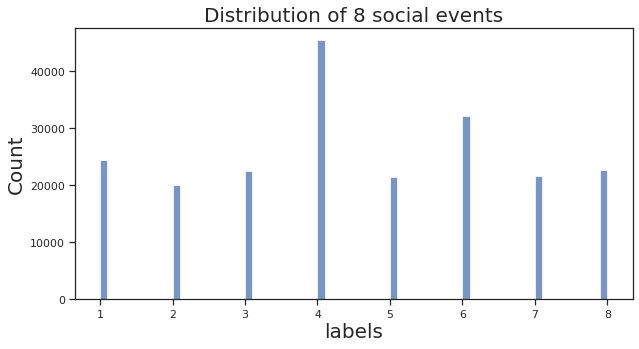

In [185]:
# Distribution before cut
combined_csv_shuffle['labels'] = combined_csv_shuffle['labels'].astype('int')

plt.figure(figsize=(10,5))
plt.title('Distribution of 8 social events')
sns.histplot(data=combined_csv_shuffle, x='labels')

In [186]:
# Balance dataset by taking equally number of rows we pre-defined earlier 
# after taking only 5th of the data from the original train set

def sampling_k(group, k=group_k):
    if len(group) < k:
        return group
    return group.sample(k)

cut_balanced_label = combined_csv_shuffle.groupby('labels').apply(sampling_k).reset_index(drop=True)

In [192]:
print('Our balanced smaller dataset has 8 events with these many rows')
print(cut_balanced_label.groupby('labels').count())

Our balanced smaller dataset has 8 events with these many rows
        filename
labels          
1           5259
2           5259
3           5259
4           5259
5           5259
6           5259
7           5259
8           5259


In [214]:
len(cut_balanced_label)

42072

In [194]:
# export balanced smaller labels to csv
os.chdir(root_dir + '/data/train-part1-labels')
combined_fifth.to_csv("combined_part1_labels.csv", index=False)

In [249]:
cut_balanced_label[cut_balanced_label['filename'].duplicated()].tail(20)

,filename,labels
20908,2360918218_af9eebe0e6.jpg,4
20911,1831418433_bcbcb26145.jpg,4
20921,15626839832_e3f00e7a9c.jpg,4
20926,mt012_0027.jpg,4
20928,3849724691_dbeb34ab12.jpg,4
20941,1273365902_faa53b7ff8.jpg,4
20948,6044516705_c5726ef9d6.jpg,4
20958,4434035968_7ebc26e690.jpg,4
20961,16240445639_f86f86a665.jpg,4
20966,mt002_0088.jpg,4


In [245]:
cut_balanced_label[cut_balanced_label['filename'] == '7550823476_ecec5ac318.jpg']            

,filename,labels
4190,7550823476_ecec5ac318.jpg,1
14639,7550823476_ecec5ac318.jpg,3


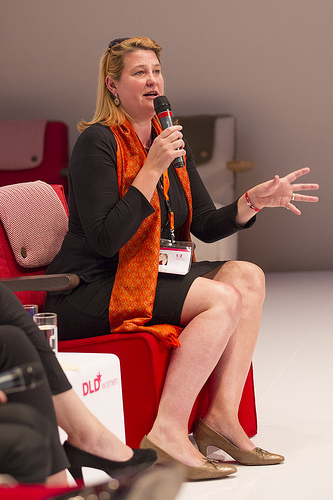

In [251]:
# How is a label 3 == meeting also a label 1 == concert
with PIL.Image.open('7550823476_ecec5ac318.jpg') as im:
    im.thumbnail((500,500), PIL.Image.ANTIALIAS)
    display(im)

In [250]:
cut_balanced_label[cut_balanced_label['filename'] == '10501619174_230e86bf29.jpg']            

,filename,labels
18110,10501619174_230e86bf29.jpg,4
19958,10501619174_230e86bf29.jpg,4
32078,10501619174_230e86bf29.jpg,7


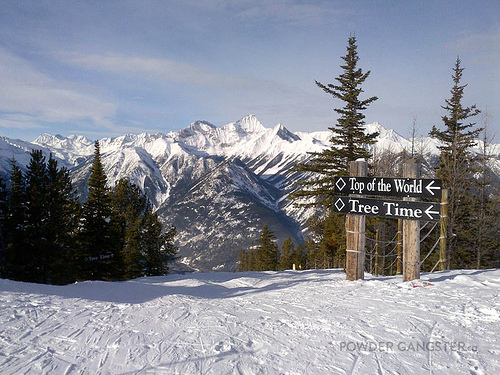

In [253]:
with PIL.Image.open('10501619174_230e86bf29.jpg') as im:
    im.thumbnail((500,500), PIL.Image.ANTIALIAS)
    display(im)

In [254]:
cut_balanced_label[cut_balanced_label['filename'] == '15989576038_786828465e.jpg']            

,filename,labels
19733,15989576038_786828465e.jpg,4
28385,15989576038_786828465e.jpg,6


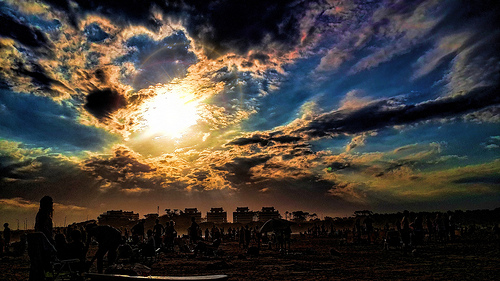

In [255]:
with PIL.Image.open('15989576038_786828465e.jpg') as im:
    im.thumbnail((500,500), PIL.Image.ANTIALIAS)
    display(im)

In [252]:
# Copy the images that are in the smaller label csv to a new folder to train on 
count = 0
os.chdir(root_dir + '/data/train-part1')
if not os.path.isdir(root_dir + 'data/train-part1-cut'):
    os.makedirs(root_dir + 'data/train-part1-cut')
    for name in cut_balanced_label['filename']:
        if os.path.exists(root_dir + 'data/train-part1/' + name):
            try:
                shutil.copy(name, root_dir + '/data/train-part1-cut')
                count += 1
            except shutil.SameFileError:
                print('same file')
            except PermissionError:
                print('permission error')
print('A total of {} unique images were copied over'.format(count))

A total of 42072 unique images were copied over


In [231]:
os.chdir(root_dir + 'data/train-part1-cut')
!ls | wc -l 

41742
